In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import vapeplot 
from scipy import interp
import scipy.stats
%matplotlib inline

#### Goal
--------------------

The goal of this project is to make a classifier that predicts the final rankings for bakers.
The idea is to make a model for each episode and to use data from previous episodes in the model.
Therefore, a classifier for episode 1 will likely be bad at predicting the final outcome, but a classifier for episode 5 might accurately predict who will be in the top 3 and who might be eliminated in the next episode



In [2]:
from datetime import datetime
def timestamp(): return datetime.today().strftime('%Y%m%d')

from sklearn.preprocessing import QuantileTransformer
def quantile_scale(df,feats):
    qua = df
    scaler = QuantileTransformer(
        n_quantiles=10,
        random_state=42,
        ignore_implicit_zeros=True, #sparse matrix
    )
    # fit the scaler
    scaler.fit(qua[feats])
    # transform values
    qua[feats] = scaler.transform(qua[feats])
    return qua
def tiered(classes):
    trans = []
    for x in classes:
        if x==1: c=0
        if x==2: c=1
        if x>=3 and x<=4: c=2
        if x>=5 and x<=7: c=3
        if x>=8: c=4
        trans.append(c)
    return trans

In [6]:
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e2.20190909.tsv".format(),sep="\t")
gbbo.head()

,season,baker,episode,place,tech_mean,tech,mean_star,star,mean_good,good,mean_bad,bad
0,10,Alice,1,0,5.0,5,0.0,0,0.0,0,0.0,0
1,10,Alice,2,0,3.0,1,0.5,1,0.5,1,0.0,0
2,10,Amelia,1,0,4.0,4,0.0,0,0.0,0,0.0,0
3,10,Amelia,2,0,6.5,9,0.0,0,0.0,0,0.5,1
4,10,Dan,1,13,9.0,9,0.0,0,0.0,0,1.0,1


In [8]:
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e2.20190909.tsv".format(),sep="\t")
feats = ['tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']
max_epi = max(gbbo['episode'])
gbbo = gbbo.loc[gbbo['episode']==max_epi]
gbbo = quantile_scale(gbbo,feats)
gbbo.head()

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2142: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"


,season,baker,episode,place,tech_mean,tech,mean_star,star,mean_good,good,mean_bad,bad
1,10,Alice,2,0,0.000000,0.083333,1.0,1.0,1.0,1.0,0.000000,0.0
3,10,Amelia,2,0,0.555556,0.750000,0.0,0.0,0.0,0.0,0.888889,1.0
5,10,Dan,2,13,0.250000,0.000000,0.0,0.0,0.0,0.0,0.888889,0.0
7,10,David,2,0,0.416667,0.166667,0.0,0.0,1.0,1.0,0.000000,0.0
9,10,Helena,2,0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [9]:
tech = pd.read_csv("../RESULTS/gbbo.features.20190909.tsv",sep='\t')
tech = tech.loc[tech['episode']==max_epi]
qua = quantile_scale(tech,feats)
qua['place']=tiered(qua['place'])
X, y = np.matrix(qua[feats]), np.array(qua['place'])

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2142: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"


In [109]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.activations import relu
input_shape = len(feats)
output_shape = len(set(tech['place']))
def create_model( nl1=1, nl2=1,  nl3=1, 
                 nn1=1000, nn2=500, nn3 = 200, lr=0.01, decay=0., l1=0.01, l2=0.01,
                act = 'relu', dropout=0,input_shape=input_shape,output_shape=output_shape):    
    '''This is a model generating function so that we can search over neural net 
    parameters and architecture
    https://www.kaggle.com/arrogantlymodest/randomised-cv-search-over-keras-neural-network
    '''
    opt = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999,  decay=decay)
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
    model = Sequential()
    first=True  
    for i in range(nl1):
        if first:
            model.add(Dense(nn1, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn1, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))    
    for i in range(nl2):
        if first:
            model.add(Dense(nn2, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn2, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))    
    for i in range(nl3):
        if first:
            model.add(Dense(nn3, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(Dense(nn3, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(Dropout(dropout))       
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'],)
    return model
##################################
l1 = 0.0001
l2 = 0.0001
lr = 0.0001
nl1 = 1
nl2 = 1
nl3 = 1
nn1 = 800
nn2 = 800
nn3 = 300

dropout = 0.1
decay = 1e-09
act='relu'
n_dims = len(feats)
n_classes = len(set(tech['place']))

nn = create_model( nl1=nl1, nl2=nl2,  nl3=nl3, 
                     nn1=nn1, nn2=nn2, nn3 = nn3, 
                     lr=lr, decay=decay, l1=l1, l2=l2,
                     act = act, dropout=dropout,
                     input_shape=n_dims,
                     output_shape=n_classes)

BATCH,EPOCHS = 12, 25
nn.fit(X,y,validation_split=0., batch_size=BATCH, epochs=EPOCHS,verbose=0)

####
tech = pd.read_csv("../RESULTS/gbbo.features.20190909.tsv",sep='\t')
tech = tech.loc[tech['episode']==max_epi]
qua = quantile_scale(tech,feats)
qua['place']=tiered(qua['place'])
X, y = np.matrix(qua[feats]), np.array(qua['place'])
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e2.20190909.tsv".format(),sep="\t")
feats = ['tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']
max_epi = max(gbbo['episode'])
gbbo = gbbo.loc[gbbo['episode']==max_epi]
gbbo = quantile_scale(gbbo,feats)
test = np.matrix(gbbo[feats])
preds = nn.predict_classes(test)
probs = nn.predict_proba(test)
gbbo['preds']=preds
# probability baker is a finalist
top = probs[:,0]
# probability baker is a finalist or a runner-up
top3 = probs[:,0]+probs[:,1]
# bottom tier (8th and below)
bot = probs[:,-1]
gbbo['bottom']=np.round(bot*100,decimals=2)
gbbo['finalist']=np.round(top*100,decimals=2) 
gbbo['top3'] = np.round(top3*100,decimals=2)
gbbo.to_csv("../RESULTS/gbbo.techinical.s10.e2.keras.preditions.txt",sep="\t",index=False)
sub = ['baker','preds','finalist','top3','bottom']
gbbo = gbbo[sub].sort_values(by=['finalist'],ascending=False)
print(gbbo)

/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2142: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"
/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2142: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"


       baker  preds   finalist       top3     bottom
15   Michael      1  26.049999  74.430000   7.440000
23     Rosie      1  24.040001  52.939999   5.120000
1      Alice      1  22.969999  71.300003   1.630000
7      David      1  18.500000  64.260002   9.820000
25     Steph      2  17.150000  44.369999   6.300000
19      Phil      3   5.650000  18.590000  25.639999
11     Henry      3   4.900000  16.250000  12.450000
21     Priya      3   2.870000  14.030000  26.440001
17  Michelle      3   2.540000  13.170000  22.889999
9     Helena      3   1.250000  10.080000  23.639999
5        Dan      4   1.040000   3.400000  88.129997
3     Amelia      4   0.880000   4.370000  47.330002
13     Jamie      4   0.330000   2.300000  72.400002


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


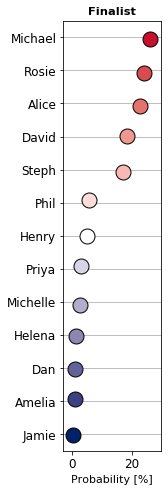

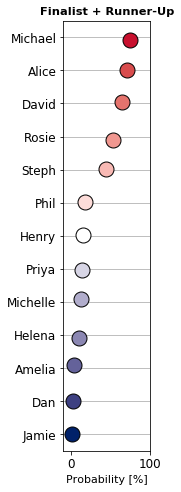

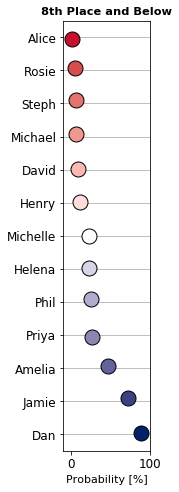

In [111]:
def plot_probs(df,x,xlab,ofh,xmin=-9,xmax=100):
    col=['#012169', '#3d4081', '#64629a', '#8b87b2', '#b1adcc', '#d7d5e5', '#ffffff', '#fddcd9', '#f8b9b4', '#f09790', '#e5736d', '#d84c4d', '#c8102e']
    colrs=reversed(col)

    vapeplot.font_size(12)
    f, ax = plt.subplots(1,1,figsize=(2.5,7))
    sns.stripplot(
        y='baker',
        x=x,
        data=df,
        linewidth=1, 
        edgecolor="k",
        size=15,
        ax=ax,
        palette=colrs
    )
    ax.set_ylabel('')
    ax.yaxis.grid(True)
    ax.set_xlim(xmin,xmax)
    ax.set_title(xlab,fontsize=11.33,weight='bold')
    ax.set_xlabel('Probability [%]',fontsize=11)
    f.tight_layout()
    f.savefig(ofh,dpi=150)
    f.show()

plot_probs(gbbo,'finalist','Finalist','../FIGURES/s10.e2.finalist.png',-3,30)   
plot_probs(gbbo.sort_values(ascending=False,by=['top3']),'top3','Finalist + Runner-Up','../FIGURES/s10.e2.top3.png')
plot_probs(gbbo.sort_values(ascending=True,by=['bottom']),'bottom','8th Place and Below','../FIGURES/s10.e2.bottom.png')

In [12]:
gbbo[sub].sort_values(by=['bottom'],ascending=False)

,baker,preds,finalist,top3,bottom
5,Dan,4,2.250000,5.870000,82.690002
13,Jamie,4,0.440000,1.910000,73.370003
3,Amelia,4,1.320000,4.800000,54.070000
21,Priya,3,4.030000,13.530000,29.510000
9,Helena,3,1.740000,8.010000,28.530001
19,Phil,3,8.110000,21.360001,27.309999
17,Michelle,3,3.680000,12.860000,26.990000
11,Henry,3,8.010000,22.129999,17.110001
15,Michael,1,23.250000,59.720001,12.990000
7,David,1,23.020000,65.339996,11.580000


In [16]:
gbbo[sub].sort_values(by=['top3'],ascending=False)

,baker,preds,finalist,top3,bottom
1,Alice,1,18.030001,57.470001,14.750000
7,David,1,17.309999,48.639999,19.809999
15,Michael,1,14.810000,41.130001,25.350000
23,Rosie,1,17.170000,41.029999,21.910000
25,Steph,4,14.320000,36.439999,25.590000
19,Phil,4,16.090000,34.639999,24.780001
11,Henry,4,15.740000,34.310001,23.990000
21,Priya,4,13.200000,30.480000,28.910000
17,Michelle,4,12.830000,29.910000,29.170000
5,Dan,4,13.470000,29.629999,35.139999


/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2142: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"
/usr/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2142: UserWarning: 'ignore_implicit_zeros' takes effect only with sparse matrix. This parameter has no effect.
  warnings.warn("'ignore_implicit_zeros' takes effect only with"
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab

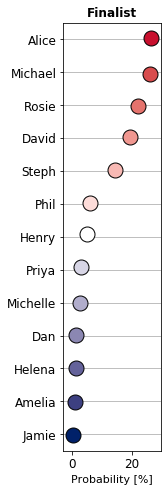

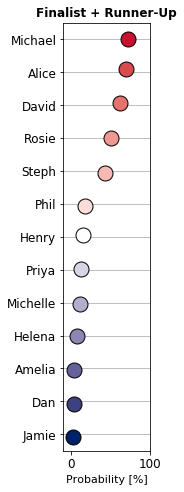

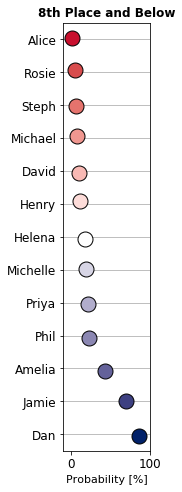

In [108]:
tech = pd.read_csv("../RESULTS/gbbo.features.20190909.tsv",sep='\t')
tech = tech.loc[(tech['episode']==2) | (tech['episode']==3)]
qua = quantile_scale(tech,feats)
qua['place']=tiered(qua['place'])
X, y = np.matrix(qua[feats]), np.array(qua['place'])
nn = create_model( nl1=nl1, nl2=nl2,  nl3=nl3, 
                     nn1=nn1, nn2=nn2, nn3 = nn3, 
                     lr=lr, decay=decay, l1=l1, l2=l2,
                     act = act, dropout=dropout,
                     input_shape=n_dims,
                     output_shape=n_classes)
nn.fit(X,y,validation_split=0., batch_size=BATCH, epochs=EPOCHS,verbose=0)
gbbo = pd.read_csv("../RESULTS/gbbo.features.s10.e2.20190909.tsv".format(),sep="\t")
feats = ['tech_mean','tech','mean_star','star','mean_good','good','mean_bad','bad']
max_epi = max(gbbo['episode'])
gbbo = gbbo.loc[gbbo['episode']==max_epi]
gbbo = quantile_scale(gbbo,feats)
test = np.matrix(gbbo[feats])
preds = nn.predict_classes(test)
probs = nn.predict_proba(test)
gbbo['preds']=preds
# probability baker is a finalist
top = probs[:,0]
top3 = probs[:,0]+probs[:,1]
bot = probs[:,-1]
gbbo['bottom']=np.round(bot*100,decimals=2)
gbbo['finalist']=np.round(top*100,decimals=2) 
gbbo['top3'] = np.round(top3*100,decimals=2)
#gbbo.to_csv("../RESULTS/gbbo.techinical.s10.e2.keras.preditions.txt",sep="\t",index=False)
sub = ['baker','preds','finalist','top3','bottom']
gbbo = gbbo[sub].sort_values(by=['finalist'],ascending=False)

plot_probs(gbbo,'finalist','Finalist','../FIGURES/s10.e2-3.finalist.png',-3,30)   
plot_probs(gbbo.sort_values(ascending=False,by=['top3']),'top3','Finalist + Runner-Up','../FIGURES/s10.e2-3.top3.png')
plot_probs(gbbo.sort_values(ascending=True,by=['bottom']),'bottom','8th Place and Below','../FIGURES/s10.e2-3.bottom.png')



In [15]:
gbbo[sub].sort_values(by=['bottom'],ascending=False)

,baker,preds,finalist,top3,bottom
5,Dan,4,1.220000,3.610000,86.370003
13,Jamie,4,0.330000,2.210000,74.680000
3,Amelia,4,1.050000,4.200000,48.380001
21,Priya,3,3.160000,13.840000,28.010000
19,Phil,3,6.140000,18.879999,27.490000
9,Helena,3,1.450000,9.640000,24.260000
17,Michelle,3,2.910000,13.020000,23.950001
11,Henry,3,5.930000,16.480000,13.520000
7,David,1,20.879999,65.339996,10.700000
15,Michael,1,26.020000,77.470001,7.590000
